# Market Regime Detection & Next-Day Return Prediction

This project builds an end-to-end machine learning pipeline on daily ETF price data to:
- Engineer a high-dimensional feature set from multiple ETFs (returns, volatility, volume-based indicators).
- Use dimensionality reduction (PCA, t-SNE) and clustering (K-Means) to explore latent **market regimes**.
- Train supervised models to predict whether the SPY ETF will close **up or down on the next trading day**.
- Connect to live data via `yfinance` to apply the trained model on recent market conditions.


## 1. Dataset Loading & Initial Exploration

In this step we:

- Download daily OHLCV data for a set of ETFs using the `yfinance` library.
- Save a static snapshot as `stocks_raw.csv` in the `data/` folder for reproducibility.
- Reload the CSV into a DataFrame `df_raw`, using the trading date as the index.

The resulting `df_raw` DataFrame (and its in-memory copy `raw`) will be the starting point for all subsequent preprocessing and feature engineering.


In [18]:
import yfinance as yf
import pandas as pd
from pathlib import Path

# --- Configuration ---
TICKERS = ["SPY", "QQQ", "IWM", "DIA", "XLK", "XLF", "XLV"]
START_DATE = "2010-01-01"
END_DATE = "2025-01-01"

DATA_PATH = Path("..") / "data" / "stocks_raw.csv"  # from notebooks/ to data/

# --- Download from Yahoo Finance ---
print("Downloading data from Yahoo Finance...")
raw = yf.download(
    tickers=TICKERS,
    start=START_DATE,
    end=END_DATE,
    auto_adjust=True
)
print("Download completed.")
print("Raw shape (in memory):", raw.shape)

# --- Save snapshot as CSV ---
DATA_PATH.parent.mkdir(parents=True, exist_ok=True)
raw.to_csv(DATA_PATH)
print(f"CSV snapshot saved to: {DATA_PATH}")

# --- Reload snapshot from CSV to verify ---
df_raw = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True)

print("\nReloaded CSV shape:", df_raw.shape)
print("Index type:", type(df_raw.index))
print("Index name:", df_raw.index.name)

print("\nFirst rows:")
display(df_raw.head())

print("\nColumn structure:")
print(type(df_raw.columns))
print(df_raw.columns[:10])


[*********************100%***********************]  7 of 7 completed

Download completed.
Raw shape (in memory): (3774, 35)
CSV snapshot saved to: ../data/stocks_raw.csv

Reloaded CSV shape: (3776, 35)
Index type: <class 'pandas.core.indexes.base.Index'>
Index name: Price

First rows:



/var/folders/8m/shg_zsjd50n33s0b7vfh1h800000gn/T/ipykernel_90431/100427662.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_raw = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True)


,Close,Close.1,Close.2,Close.3,Close.4,Close.5,Close.6,High,High.1,High.2,...,Open.4,Open.5,Open.6,Volume,Volume.1,Volume.2,Volume.3,Volume.4,Volume.5,Volume.6
Price,,,,,,,,,,,,,,,,,,,,,
Ticker,DIA,IWM,QQQ,SPY,XLF,XLK,XLV,DIA,IWM,QQQ,...,XLF,XLK,XLV,DIA,IWM,QQQ,SPY,XLF,XLK,XLV
Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,75.13215637207031,51.63050842285156,40.3935661315918,85.27919006347656,9.019766807556152,18.809371948242188,24.186010360717773,75.28148140998198,51.67892826391517,40.4544815021829,...,8.915385860053387,18.704290796727538,24.078890058462033,8977300,42863900,62822800,118944600,92942347,8449400,5580900
2010-01-05,75.01127624511719,51.45295715332031,40.3935661315918,85.50494384765625,9.185551643371582,18.785118103027344,23.948814392089844,75.13926992119237,51.79188978565341,40.46318180114858,...,9.00748977019142,18.833616255563772,24.14775041046582,6549200,55523100,62935600,111579900,96770018,19988200,5428600
2010-01-06,75.06102752685547,51.404563903808594,40.149906158447266,85.56514739990234,9.203970909118652,18.57495880126953,24.193653106689453,75.26723979671772,51.72735366298512,40.506678061705394,...,9.179410851676556,18.785119533906812,23.948807833094495,6797200,59708600,96033000,116074400,75492798,10024100,4883600



Column structure:
<class 'pandas.core.indexes.base.Index'>
Index(['Close', 'Close.1', 'Close.2', 'Close.3', 'Close.4', 'Close.5',
       'Close.6', 'High', 'High.1', 'High.2'],
      dtype='object')


## 2. Base Price, Volume and Returns Tables

The raw `yfinance` download is a DataFrame indexed by trading date with a **MultiIndex** on the columns:

- Level 0: price/volume fields (`Open`, `High`, `Low`, `Close`, `Adj Close`, `Volume`, …)
- Level 1: ticker symbols (`SPY`, `QQQ`, `IWM`, `DIA`, `XLK`, `XLF`, `XLV`).

To prepare for feature engineering, we:

1. Extract **Adjusted Close** prices for all tickers into a `close` table.
2. Extract **Volume** for all tickers into a `volume` table.
3. Compute **daily percentage returns** from `close`, which will be used to build technical features later.

After this step we have:
- `close`: adjusted prices per ticker and day.
- `volume`: traded volume per ticker and day.
- `returns`: daily percentage returns per ticker and day.
- `TICKERS`: the list of tickers used throughout the project.


In [20]:
import pandas as pd

# Work from the in-memory yfinance DataFrame
df_raw = raw.copy()

print("df_raw type:", type(df_raw))
print("Index type:", type(df_raw.index))

if not isinstance(df_raw.columns, pd.MultiIndex):
    raise ValueError(
        "Expected MultiIndex columns from yf.download for multiple tickers. "
        "Inspect df_raw.columns and adjust if needed."
    )

print("First few column tuples:")
print(df_raw.columns[:10])

level0 = df_raw.columns.get_level_values(0)

if "Adj Close" in level0:
    price_field = "Adj Close"
elif "Close" in level0:
    price_field = "Close"
else:
    raise KeyError(
        "Neither 'Adj Close' nor 'Close' found in the first level of df_raw.columns"
    )

print(f"\nUsing price field: {price_field}")

# --- Extract price and volume per ticker ---
close = df_raw[price_field].copy()
volume = df_raw["Volume"].copy()

print("\nClose shape:", close.shape)
print("Volume shape:", volume.shape)
display(close.head())
display(volume.head())

# --- Compute daily percentage returns ---
returns = close.pct_change()
print("\nReturns shape:", returns.shape)
display(returns.head())

# Keep a list of tickers for later steps
TICKERS = list(close.columns)
print("\nTickers used:", TICKERS)


df_raw type: <class 'pandas.core.frame.DataFrame'>
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
First few column tuples:
MultiIndex([('Close', 'DIA'),
            ('Close', 'IWM'),
            ('Close', 'QQQ'),
            ('Close', 'SPY'),
            ('Close', 'XLF'),
            ('Close', 'XLK'),
            ('Close', 'XLV'),
            ( 'High', 'DIA'),
            ( 'High', 'IWM'),
            ( 'High', 'QQQ')],
           names=['Price', 'Ticker'])

Using price field: Close

Close shape: (3774, 7)
Volume shape: (3774, 7)


Ticker,DIA,IWM,QQQ,SPY,XLF,XLK,XLV
Date,,,,,,,
2010-01-04,75.132156,51.630508,40.393566,85.279190,9.019767,18.809372,24.186010
2010-01-05,75.011276,51.452957,40.393566,85.504944,9.185552,18.785118,23.948814
2010-01-06,75.061028,51.404564,40.149906,85.565147,9.203971,18.574959,24.193653
2010-01-07,75.331291,51.783806,40.176022,85.926369,9.400455,18.502224,24.277822
2010-01-08,75.452156,52.066265,40.506676,86.212280,9.345191,18.623466,24.316074


Ticker,DIA,IWM,QQQ,SPY,XLF,XLK,XLV
Date,,,,,,,
2010-01-04,8977300,42863900,62822800,118944600,92942347,8449400,5580900
2010-01-05,6549200,55523100,62935600,111579900,96770018,19988200,5428600
2010-01-06,6797200,59708600,96033000,116074400,75492798,10024100,4883600
2010-01-07,6312000,56123500,77094100,131091100,117869112,7292400,6114600
2010-01-08,4912000,48811500,88886600,126402800,111866140,11886200,4284800



Returns shape: (3774, 7)


Ticker,DIA,IWM,QQQ,SPY,XLF,XLK,XLV
Date,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,-0.001609,-0.003439,0.000000,0.002647,0.018380,-0.001289,-0.009807
2010-01-06,0.000663,-0.000941,-0.006032,0.000704,0.002005,-0.011188,0.010223
2010-01-07,0.003601,0.007378,0.000650,0.004222,0.021348,-0.003916,0.003479
2010-01-08,0.001604,0.005455,0.008230,0.003327,-0.005879,0.006553,0.001576



Tickers used: ['DIA', 'IWM', 'QQQ', 'SPY', 'XLF', 'XLK', 'XLV']


## 3. High-Dimensional Feature Engineering

To obtain a high-dimensional feature space (≥ 50 features), we build multiple technical-style features per ticker using the price returns and traded volume.

For each ticker we compute:

- **Lagged returns**: previous 1, 2, 5 and 10 days.
- **Rolling mean of returns**: windows of 5, 10, 20 and 50 days.
- **Rolling volatility (std of returns)**: windows of 5, 10, 20 and 50 days.
- **Volume-based features**:
  - Rolling volume mean over 5 and 20 days.
  - Volume relative to its 20-day moving average.

These features are concatenated across all ETFs in our universe, producing a high-dimensional feature matrix where:

- Each row = one trading day.
- Each column = one engineered signal for a specific ticker.

Because we use multiple windows and several tickers, the final feature count comfortably exceeds the **50-feature** requirement of the project.


In [21]:
import pandas as pd


def build_features(close_df: pd.DataFrame,
                   volume_df: pd.DataFrame,
                   returns_df: pd.DataFrame,
                   tickers: list) -> pd.DataFrame:
    """
    Build a high-dimensional feature table from prices, volume and returns.
    Features are computed per ticker and concatenated for all tickers.
    """
    feats = pd.DataFrame(index=close_df.index)

    lag_list = [1, 2, 5, 10]
    mean_windows = [5, 10, 20, 50]
    vol_windows = [5, 10, 20, 50]
    vol_ma_windows = [5, 20]

    for ticker in tickers:
        r = returns_df[ticker]
        v = volume_df[ticker]

        # Lagged returns
        for lag in lag_list:
            feats[f"{ticker}_ret_lag{lag}"] = r.shift(lag)

        # Rolling mean of returns
        for win in mean_windows:
            feats[f"{ticker}_ret_mean_{win}"] = r.rolling(win).mean()

        # Rolling volatility (std of returns)
        for win in vol_windows:
            feats[f"{ticker}_ret_std_{win}"] = r.rolling(win).std()

        # Volume moving averages
        for win in vol_ma_windows:
            feats[f"{ticker}_vol_ma_{win}"] = v.rolling(win).mean()

        # Volume relative to 20-day moving average
        vol_ma_20 = v.rolling(20).mean()
        feats[f"{ticker}_vol_rel_20"] = v / vol_ma_20

    return feats

# Build the feature matrix
features = build_features(close, volume, returns, TICKERS)

print("Features shape (rows, cols):", features.shape)
print("Number of features (columns):", features.shape[1])

display(features.head())
print("\nSample of feature columns:")
print(list(features.columns[:15]))

nan_counts = features.isna().sum().sort_values(ascending=False)
print("\nTop 10 features by NaN count (due to initial windows):")
print(nan_counts.head(10))


Features shape (rows, cols): (3774, 105)
Number of features (columns): 105


/var/folders/8m/shg_zsjd50n33s0b7vfh1h800000gn/T/ipykernel_90431/3729599768.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats[f"{ticker}_ret_std_{win}"] = r.rolling(win).std()
/var/folders/8m/shg_zsjd50n33s0b7vfh1h800000gn/T/ipykernel_90431/3729599768.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats[f"{ticker}_ret_std_{win}"] = r.rolling(win).std()
/var/folders/8m/shg_zsjd50n33s0b7vfh1h800000gn/T/ipykernel_90431/3729599768.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

,DIA_ret_lag1,DIA_ret_lag2,DIA_ret_lag5,DIA_ret_lag10,DIA_ret_mean_5,DIA_ret_mean_10,DIA_ret_mean_20,DIA_ret_mean_50,DIA_ret_std_5,DIA_ret_std_10,...,XLV_ret_mean_10,XLV_ret_mean_20,XLV_ret_mean_50,XLV_ret_std_5,XLV_ret_std_10,XLV_ret_std_20,XLV_ret_std_50,XLV_vol_ma_5,XLV_vol_ma_20,XLV_vol_rel_20
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,-0.001609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,0.000663,-0.001609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,0.003601,0.000663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5258500.0,NaN,NaN



Sample of feature columns:
['DIA_ret_lag1', 'DIA_ret_lag2', 'DIA_ret_lag5', 'DIA_ret_lag10', 'DIA_ret_mean_5', 'DIA_ret_mean_10', 'DIA_ret_mean_20', 'DIA_ret_mean_50', 'DIA_ret_std_5', 'DIA_ret_std_10', 'DIA_ret_std_20', 'DIA_ret_std_50', 'DIA_vol_ma_5', 'DIA_vol_ma_20', 'DIA_vol_rel_20']

Top 10 features by NaN count (due to initial windows):
SPY_ret_mean_50    50
SPY_ret_std_50     50
QQQ_ret_mean_50    50
IWM_ret_mean_50    50
XLF_ret_mean_50    50
XLK_ret_mean_50    50
XLK_ret_std_50     50
DIA_ret_std_50     50
IWM_ret_std_50     50
DIA_ret_mean_50    50
dtype: int64


## 4. Target Definition and Final Modeling Dataset

For the supervised learning task we want to predict whether **SPY closes up or down on the next trading day**.

We proceed as follows:

1. Compute SPY's daily return from the `close` price series.
2. Define a binary target:
   - `1` if **next-day** SPY return is positive.
   - `0` otherwise.
3. Attach this `target_up` column to the `features` table.
4. Drop any rows with missing values (caused by rolling windows, lags, or the target shift).

The result is a clean modeling dataset:

- `data`: all engineered features plus the `target_up` label.
- `X`: feature matrix (all columns except `target_up`).
- `y`: target vector (0/1, next-day SPY direction).

In [22]:
# --- 4.1 Compute SPY daily returns and target ---
# SPY price series from the `close` table
spy_price = close["SPY"]

# Daily % returns
spy_returns = spy_price.pct_change()

# Binary target: 1 if next-day return > 0, else 0
target_up = (spy_returns.shift(-1) > 0).astype(int)

print("Sample of SPY returns:")
display(spy_returns.head(10))

print("\nSample of target_up (before alignment/dropna):")
display(target_up.head(10))

# --- 4.2 Combine features and target, then drop NaNs ---
data = features.copy()
data["target_up"] = target_up

print("\nShape before dropna:", data.shape)
data = data.dropna()
print("Shape after dropna (final modeling dataset):", data.shape)

# --- 4.3 Separate features X and target y ---
X = data.drop(columns=["target_up"])
y = data["target_up"]

print("\nFinal feature matrix X shape:", X.shape)
print("Final target vector y shape:", y.shape)

print("\nClass distribution (target_up):")
print(y.value_counts())
print("\nClass distribution (proportions):")
print(y.value_counts(normalize=True))


Sample of SPY returns:


Date
2010-01-04         NaN
2010-01-05    0.002647
2010-01-06    0.000704
2010-01-07    0.004222
2010-01-08    0.003327
2010-01-11    0.001397
2010-01-12   -0.009326
2010-01-13    0.008446
2010-01-14    0.002705
2010-01-15   -0.011224
Name: SPY, dtype: float64


Sample of target_up (before alignment/dropna):


Date
2010-01-04    1
2010-01-05    1
2010-01-06    1
2010-01-07    1
2010-01-08    1
2010-01-11    0
2010-01-12    1
2010-01-13    1
2010-01-14    0
2010-01-15    1
Name: SPY, dtype: int64


Shape before dropna: (3774, 106)
Shape after dropna (final modeling dataset): (3724, 106)

Final feature matrix X shape: (3724, 105)
Final target vector y shape: (3724,)

Class distribution (target_up):
target_up
1    2051
0    1673
Name: count, dtype: int64

Class distribution (proportions):
target_up
1    0.550752
0    0.449248
Name: proportion, dtype: float64


## 5. Train / Validation / Test Split and Feature Scaling

Since we are working with **time series data**, we avoid random shuffling and instead perform a **time-based split**:

- **Training set**: earliest dates up to a cutoff (e.g. end of 2018).
- **Validation set**: intermediate period (e.g. 2019–2021) used for model selection.
- **Test set**: most recent period (e.g. 2022 onward) used for final evaluation.

Then we:

1. Split `X` and `y` according to these date ranges.
2. Standardize all features using `StandardScaler`:
   - Fit the scaler **only on the training set**.
   - Apply the same transformation to validation and test sets.

The outputs of this step are:

- `X_train`, `X_val`, `X_test` (original DataFrames).
- `y_train`, `y_val`, `y_test`.
- `X_train_scaled`, `X_val_scaled`, `X_test_scaled` (NumPy arrays ready for PCA and models).
- `scaler` object, which we’ll reuse later for PCA and for applying the model to new data.


In [23]:
from sklearn.preprocessing import StandardScaler
import numpy as np

dates = data.index

train_end = "2018-12-31"
val_end = "2021-12-31"

train_mask = dates <= train_end
val_mask = (dates > train_end) & (dates <= val_end)
test_mask = dates > val_end

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

print("Train shape:", X_train.shape, " | y_train:", y_train.shape)
print("Val shape:  ", X_val.shape,   " | y_val:", y_val.shape)
print("Test shape: ", X_test.shape,  " | y_test:", y_test.shape)

print("\nTrain date range:", X_train.index.min(), "to", X_train.index.max())
print("Val date range:  ", X_val.index.min(), "to", X_val.index.max())
print("Test date range: ", X_test.index.min(), "to", X_test.index.max())

# --- Standardize features ---
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Sanity check
print("\nScaled train feature matrix shape:", X_train_scaled.shape)
print("Approx mean of first 5 features in train:", np.mean(X_train_scaled, axis=0)[:5])
print("Approx std of first 5 features in train:", np.std(X_train_scaled, axis=0)[:5])


Train shape: (2214, 105)  | y_train: (2214,)
Val shape:   (757, 105)  | y_val: (757,)
Test shape:  (753, 105)  | y_test: (753,)

Train date range: 2010-03-17 00:00:00 to 2018-12-31 00:00:00
Val date range:   2019-01-02 00:00:00 to 2021-12-31 00:00:00
Test date range:  2022-01-03 00:00:00 to 2024-12-31 00:00:00

Scaled train feature matrix shape: (2214, 105)
Approx mean of first 5 features in train: [ 1.20349379e-17 -3.20931678e-18 -9.62795035e-18 -2.40698759e-18
 -9.62795035e-18]
Approx std of first 5 features in train: [1. 1. 1. 1. 1.]


## 6. Principal Component Analysis (PCA)

We now apply PCA to the standardized training features to:

1. Understand how many components are needed to explain most of the variance.
2. Create a lower-dimensional representation that we can use for:
   - Visualization (2D plots of the data structure).
   - Comparing model performance **with vs. without** dimensionality reduction.

In this step we:

- Fit a PCA model on `X_train_scaled`.
- Plot the **cumulative explained variance** as a function of the number of components.
- Choose a reasonable number of components (e.g. 20) that captures most of the variance.
- Transform train/validation/test sets into this PCA space.
- Visualize the first two principal components, colored by the target (`target_up`) to see whether there is any visible separation between "up" and "down" days.


Number of original features: 105


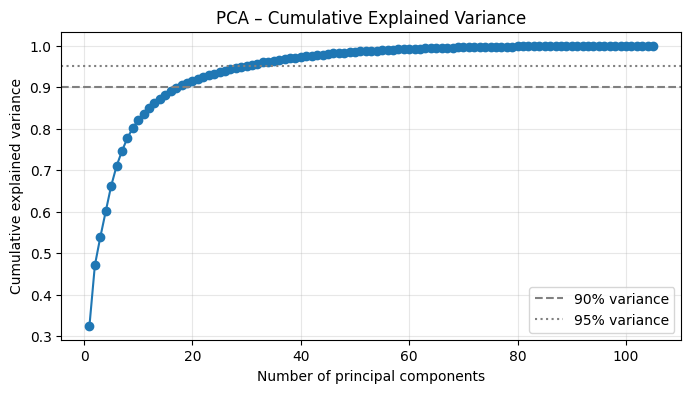


PCA with 20 components
X_train_pca shape: (2214, 20)
X_val_pca shape:   (757, 20)
X_test_pca shape:  (753, 20)


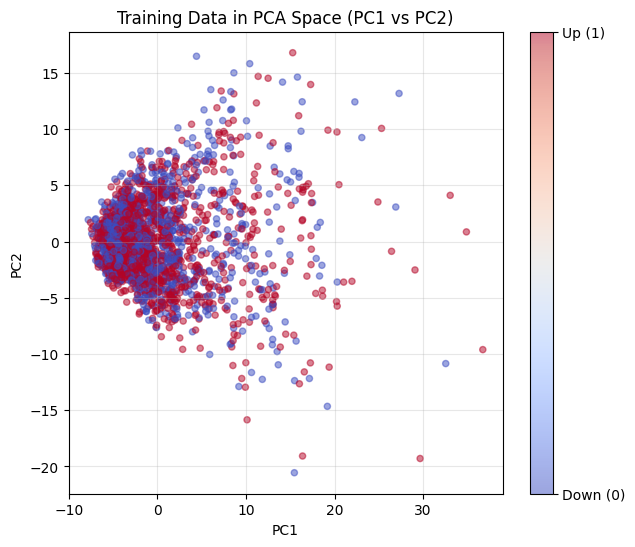

In [24]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- 6.1 Fit PCA on the standardized training features ---
pca_full = PCA()
pca_full.fit(X_train_scaled)

explained_var_ratio = pca_full.explained_variance_ratio_
cumulative_var = explained_var_ratio.cumsum()

print("Number of original features:", X_train_scaled.shape[1])

# --- 6.2 Plot cumulative explained variance ---
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker="o")
plt.axhline(0.90, color="gray", linestyle="--", label="90% variance")
plt.axhline(0.95, color="gray", linestyle=":", label="95% variance")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA – Cumulative Explained Variance")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# --- 6.3 Choose a fixed number of components ---
N_COMPONENTS = 20

pca = PCA(n_components=N_COMPONENTS)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"\nPCA with {N_COMPONENTS} components")
print("X_train_pca shape:", X_train_pca.shape)
print("X_val_pca shape:  ", X_val_pca.shape)
print("X_test_pca shape: ", X_test_pca.shape)

# --- 6.4 Visualize first two principal components colored by target ---
plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    X_train_pca[:, 0],
    X_train_pca[:, 1],
    c=y_train,
    cmap="coolwarm",
    alpha=0.5,
    s=20,
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Training Data in PCA Space (PC1 vs PC2)")
cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.ax.set_yticklabels(["Down (0)", "Up (1)"])
plt.grid(True, alpha=0.3)
plt.show()


## 7. t-SNE Visualization of the Training Data

While PCA is a **linear** dimensionality reduction method, t-SNE is a **non-linear** technique that focuses on preserving local neighborhood structure when embedding high-dimensional data into 2D (or 3D).

Here we:

1. Take a **subset** of the standardized training data (`X_train_scaled`) for computational efficiency.
2. Run t-SNE to obtain a 2D embedding.
3. Plot the embedded points, colored by the target `target_up` (up vs down day).

The goal is to see whether a more flexible non-linear embedding reveals any clearer separation or clustering structure than the first two principal components did.


Running t-SNE on 2000 training samples...
t-SNE embedding shape: (2000, 2)


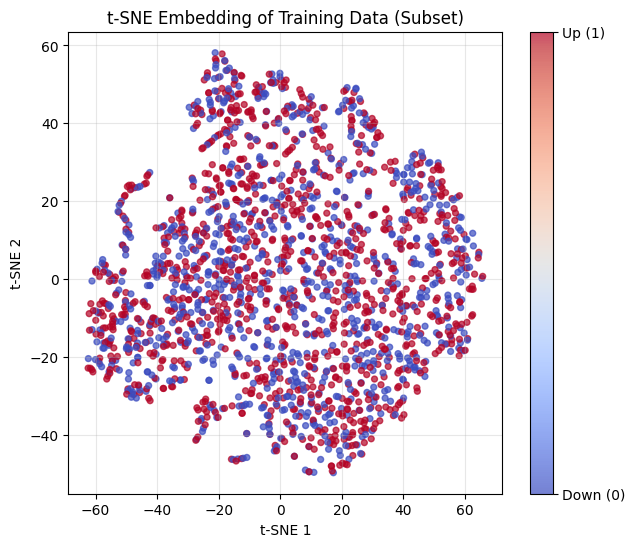

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# --- 7.1 Select a subset of training samples for t-SNE (for speed) ---
MAX_TSNE_SAMPLES = 2000

n_train = X_train_scaled.shape[0]
tsne_size = min(MAX_TSNE_SAMPLES, n_train)

X_tsne_input = X_train_scaled[:tsne_size]
y_tsne_input = y_train.iloc[:tsne_size]

print(f"Running t-SNE on {tsne_size} training samples...")

# --- 7.2 Run t-SNE ---
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42,
    init="pca"
)

X_tsne_2d = tsne.fit_transform(X_tsne_input)

print("t-SNE embedding shape:", X_tsne_2d.shape)

# --- 7.3 Plot t-SNE embedding colored by target ---
plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    X_tsne_2d[:, 0],
    X_tsne_2d[:, 1],
    c=y_tsne_input,
    cmap="coolwarm",
    alpha=0.7,
    s=18,
)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Embedding of Training Data (Subset)")
cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.ax.set_yticklabels(["Down (0)", "Up (1)"])
plt.grid(True, alpha=0.3)
plt.show()


## 8. K-Means Clustering on PCA Components (Market Regimes)

We now use the PCA representation to perform **unsupervised clustering** of market days, with the goal of discovering latent **market regimes**.

Steps:

1. Use the PCA-transformed training data (`X_train_pca`) as input.
2. Try several values of `K` (e.g. 2–6) and compute the **silhouette score** for each, to get a sense of reasonable cluster counts.
3. Choose a specific `K` (e.g. 3 or 4) based on the scores and interpretability.
4. Fit a final `KMeans` model on `X_train_pca` and assign clusters to:
   - Training data (`cluster_train`)
   - Validation data (`cluster_val`)
   - Test data (`cluster_test`)
5. Visualize the clusters in the 2D PCA space (PC1 vs PC2).
6. Compute simple statistics per cluster (average SPY return, probability of up day) to interpret the regimes.

These “regimes” will later help us analyze whether some clusters correspond to predominantly bullish, bearish, or neutral periods.

K = 2: silhouette score = 0.4020
K = 3: silhouette score = 0.1890
K = 4: silhouette score = 0.1752
K = 5: silhouette score = 0.1527
K = 6: silhouette score = 0.1361


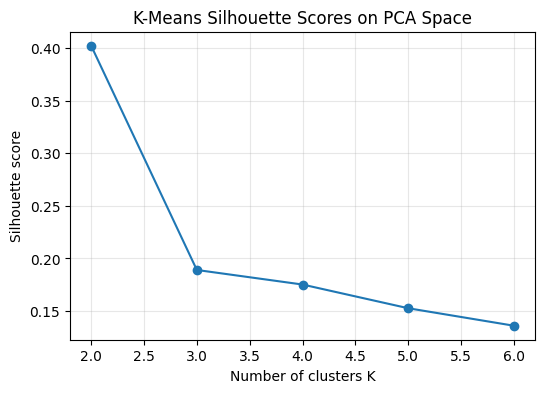

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# --- 8.1 Search for a reasonable K using silhouette scores ---
possible_K = range(2, 7)  # K = 2,3,4,5,6
sil_scores = []

for k in possible_K:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_train_pca)
    score = silhouette_score(X_train_pca, labels)
    sil_scores.append(score)
    print(f"K = {k}: silhouette score = {score:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(list(possible_K), sil_scores, marker="o")
plt.xlabel("Number of clusters K")
plt.ylabel("Silhouette score")
plt.title("K-Means Silhouette Scores on PCA Space")
plt.grid(True, alpha=0.3)
plt.show()


### 8.2 Fit final K-Means model and visualize regimes

Using the chosen number of clusters `N_CLUSTERS`, we:

- Fit `KMeans` on `X_train_pca`.
- Predict cluster labels for train, validation and test sets.
- Visualize the training samples in the (PC1, PC2) plane, colored by cluster ID, to see the structure of regimes.
- Summarize each cluster in terms of:
  - Average SPY daily return.
  - Probability that SPY closes up (fraction of `target_up = 1`).


Cluster labels in train (first 20): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


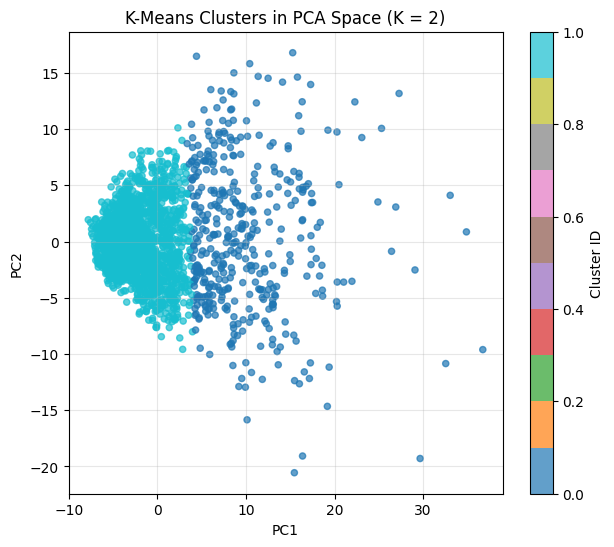

In [28]:
# --- 8.2 Fit final K-Means and assign clusters ---

N_CLUSTERS = 2

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init="auto")
cluster_train = kmeans.fit_predict(X_train_pca)
cluster_val = kmeans.predict(X_val_pca)
cluster_test = kmeans.predict(X_test_pca)

print("Cluster labels in train (first 20):", cluster_train[:20])

# --- 8.3 Visualize clusters in PCA PC1–PC2 space ---
plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    X_train_pca[:, 0],
    X_train_pca[:, 1],
    c=cluster_train,
    cmap="tab10",
    alpha=0.7,
    s=20,
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"K-Means Clusters in PCA Space (K = {N_CLUSTERS})")
cbar = plt.colorbar(scatter)
cbar.set_label("Cluster ID")
plt.grid(True, alpha=0.3)
plt.show()


## 9. Supervised Models on Original vs PCA-Reduced Features

To evaluate the impact of dimensionality reduction, we train two types of classifiers:

1. **Logistic Regression** – a linear baseline.
2. **Random Forest** – a non-linear ensemble model.

For each model, we compare two training setups:

- **Full feature space**: using all 105 standardized features (`X_train_scaled`, `X_test_scaled`).
- **PCA-reduced space**: using the 20 principal components (`X_train_pca`, `X_test_pca`).

For each combination we report:

- Accuracy
- F1-score (positive class = "up day")
- ROC-AUC

and we print a classification report and confusion matrix for the best-performing setup.

This allows us to discuss whether PCA helps or hurts predictive performance relative to the original high-dimensional feature space.


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)
import numpy as np
import pandas as pd

def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    """
    Fit model on (X_tr, y_tr) and evaluate on (X_te, y_te).
    Returns a dict of metrics and prints a short summary.
    """
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_te)[:, 1]
        roc = roc_auc_score(y_te, y_proba)
    else:
        roc = np.nan

    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred)

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.3f}")
    print(f"F1-score: {f1:.3f}")
    if not np.isnan(roc):
        print(f"ROC-AUC:  {roc:.3f}")

    return {
        "model": name,
        "accuracy": acc,
        "f1": f1,
        "roc_auc": roc,
    }

results = []

# --- 9.2.1 Logistic Regression on full features ---
log_reg_full = LogisticRegression(max_iter=1000, n_jobs=-1)
res_lr_full = evaluate_model(
    "Logistic Regression (full features)",
    log_reg_full,
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test,
)
results.append(res_lr_full)

# --- 9.2.2 Logistic Regression on PCA features ---
log_reg_pca = LogisticRegression(max_iter=1000, n_jobs=-1)
res_lr_pca = evaluate_model(
    "Logistic Regression (PCA-20)",
    log_reg_pca,
    X_train_pca,
    y_train,
    X_test_pca,
    y_test,
)
results.append(res_lr_pca)

# --- 9.2.3 Random Forest on full features ---
rf_full = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
)
res_rf_full = evaluate_model(
    "Random Forest (full features)",
    rf_full,
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test,
)
results.append(res_rf_full)

# --- 9.2.4 Random Forest on PCA features ---
rf_pca = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
)
res_rf_pca = evaluate_model(
    "Random Forest (PCA-20)",
    rf_pca,
    X_train_pca,
    y_train,
    X_test_pca,
    y_test,
)
results.append(res_rf_pca)

# --- 9.2.5 Summarize results in a table ---
results_df = pd.DataFrame(results)
display(results_df)



=== Logistic Regression (full features) ===
Accuracy: 0.498
F1-score: 0.279
ROC-AUC:  0.485

=== Logistic Regression (PCA-20) ===
Accuracy: 0.539
F1-score: 0.664
ROC-AUC:  0.521

=== Random Forest (full features) ===
Accuracy: 0.527
F1-score: 0.611
ROC-AUC:  0.511

=== Random Forest (PCA-20) ===
Accuracy: 0.537
F1-score: 0.644
ROC-AUC:  0.520


,model,accuracy,f1,roc_auc
0,Logistic Regression (full features),0.498008,0.278626,0.484502
1,Logistic Regression (PCA-20),0.539177,0.664085,0.520810
2,Random Forest (full features),0.527224,0.611354,0.511084
3,Random Forest (PCA-20),0.536521,0.643514,0.520322


### 9.4 Baseline: Always Predict "Up" Day

To interpret the model performance, we compare it against a simple naive baseline:

- Always predict `target_up = 1` (i.e. assume SPY will go up every day).

Given that ~55% of days in the dataset are up days, this baseline is expected to achieve:

- Accuracy ≈ 0.55
- F1-score ≈ 0.71 for the positive class

If our models do not significantly outperform this baseline, it suggests that—at least with this feature set and daily frequency—there is limited exploitable predictive signal beyond the historical tendency of the market to drift upwards.


In [30]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Baseline: always predict "up" (1)
y_pred_baseline = np.ones_like(y_test)

baseline_acc = accuracy_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline)

print("=== Baseline: Always predict 'up' (1) ===")
print(f"Accuracy: {baseline_acc:.3f}")
print(f"F1-score: {baseline_f1:.3f}")


=== Baseline: Always predict 'up' (1) ===
Accuracy: 0.526
F1-score: 0.689
